# CNN

In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

### Load Data

In [2]:
#Transformation for image
transform_ori = transforms.Compose([transforms.Resize((64, 64)),   #create 64x64 image
                                    #transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#normalize the image
                                   ])  
                                    
#Load our dataset
train_dataset = datasets.ImageFolder(root = './train',
                                     transform = transform_ori)

test_dataset = datasets.ImageFolder(root = './test',
                                    transform = transform_ori)

#Make the dataset iterable
batch_size = 10
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)      #Shuffle to create a mixed batches of 100 of images

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

### Show some of image

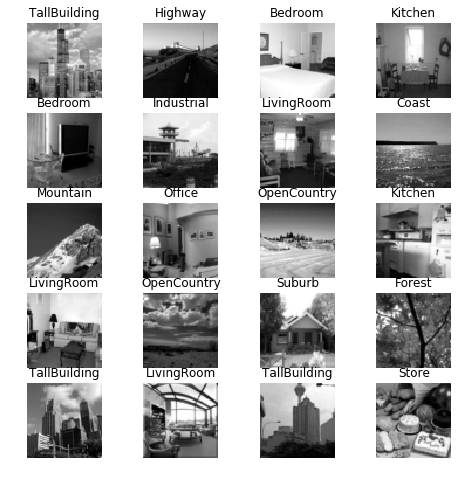

In [3]:
labels_map = {0 : 'Bedroom', 1 : 'Coast', 2 : 'Forest', 3 : 'Highway', 4 : 'Industrial', 5 : 'InsideCity', 6 : 'Kitchen',
              7 : 'LivingRoom', 8 : 'Mountain', 9 : 'Office', 10 : 'OpenCountry', 11 : 'Store', 12 : 'Street', 13 : 'Suburb',
              14 : 'TallBuilding'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),#kernel_size=3/5,padding=1/2
            nn.BatchNorm2d(num_features =64),
            nn.ReLU(),
            #nn.MaxPool2d(4)) #Maxpooling reduces the size by kernel size. 64/4 = 16
            nn.MaxPool2d(2)) #Maxpooling reduces the size by kernel size. 64/2 = 32
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features =64),
            nn.ReLU(),
            #nn.MaxPool2d(4)) #Maxpooling reduces the size by kernel size. 16/4 = 4
            nn.MaxPool2d(2)) #Maxpooling reduces the size by kernel size. 32/2 = 16
        
#         self.fc = nn.Sequential( #have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
#             nn.Linear(16*16*64, 2000),
#             nn.Dropout(p=0.5),                    #Dropout used to reduce overfitting
#             nn.Linear(2000, 500),
#             nn.Dropout(p=0.5), 
#             nn.Linear(500, 10)
#         )
        
        #self.fc = nn.Linear(8*8*64, 10)
        self.fc = nn.Linear(16*16*64, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
optimizer = torch.optim.Adam(model.parameters())

In [6]:
num_epochs = 50

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
start = time.time()

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item() 
        iterations += 1
    
    # Record the training loss
#     print(iterations,len(train_dataset))
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        iterations += 1

    # Record the Testing accuracy
    test_accuracy.append((correct / len(test_dataset)))
    
    if epoch % 5 == 0 or epoch+1 == num_epochs:
        print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_accuracy[-1]))

end = time.time()
print('Time: {}s'.format(end-start))

Epoch 1/50, Training Loss: 3.023, Training Accuracy: 0.122, Testing Acc: 0.160
Epoch 6/50, Training Loss: 1.575, Training Accuracy: 0.413, Testing Acc: 0.293
Epoch 11/50, Training Loss: 1.376, Training Accuracy: 0.515, Testing Acc: 0.307
Epoch 16/50, Training Loss: 1.223, Training Accuracy: 0.584, Testing Acc: 0.340
Epoch 21/50, Training Loss: 1.180, Training Accuracy: 0.610, Testing Acc: 0.333
Epoch 26/50, Training Loss: 1.137, Training Accuracy: 0.619, Testing Acc: 0.347
Epoch 31/50, Training Loss: 1.098, Training Accuracy: 0.627, Testing Acc: 0.340
Epoch 36/50, Training Loss: 1.058, Training Accuracy: 0.645, Testing Acc: 0.307
Epoch 41/50, Training Loss: 1.065, Training Accuracy: 0.647, Testing Acc: 0.327
Epoch 46/50, Training Loss: 1.085, Training Accuracy: 0.641, Testing Acc: 0.313
Epoch 50/50, Training Loss: 1.047, Training Accuracy: 0.653, Testing Acc: 0.307
Time: 233.26356863975525s


In [8]:
def SaveModel():
    #Run this if you want to save the model
    torch.save(model.state_dict(),'animal-10_3.pth')
    
def LoadModel():
    #Run this if you want to load the model
    model.load_state_dict(torch.load('animal-10.pth'))

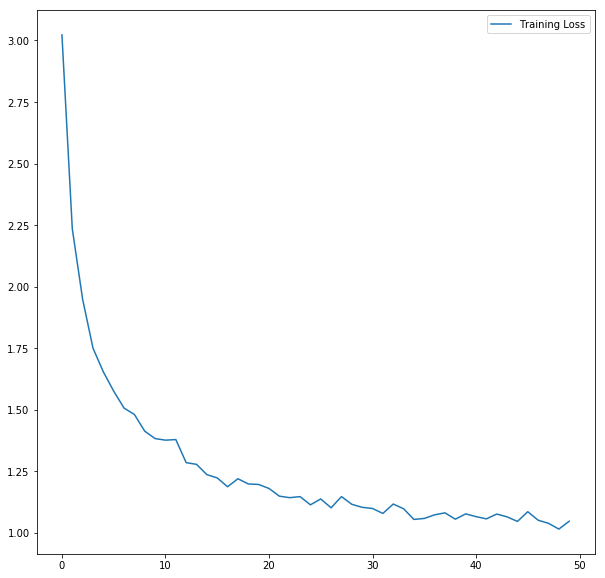

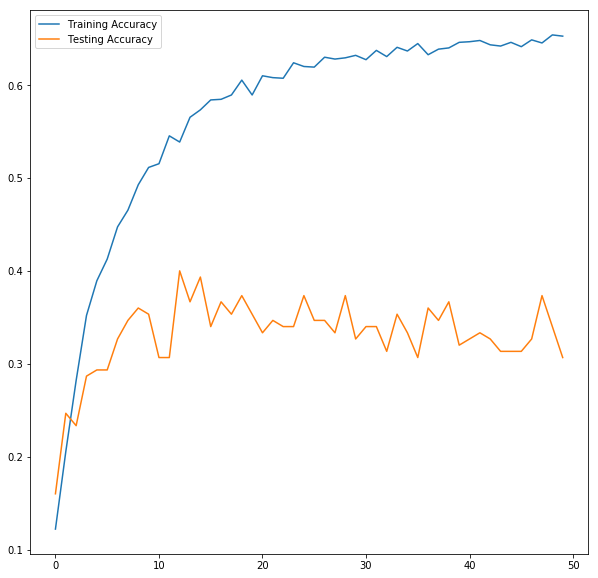

In [9]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
#plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()




In [10]:
def predict(img_name,model):
    image = Image.open(img_name).convert('RGB')
#     img = Image.fromarray(image)      #Convert the image to an array
#     img = transforms_photo(img)     #Apply the transformations 
    img = transform_ori(image)
    img = img.view(1,3,64,64)       #Add batch size 
    img = Variable(img)      
#     #Wrap the tensor to a variable
    
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    p = labels_map[predicted.item()]

    plt.subplot(1,2,1),plt.imshow(image),plt.axis('off')
    plt.subplot(1,2,2),plt.imshow(img[0][0,:,:].cpu(), cmap='gray'),plt.axis('off')
    return  p
    

# pred = predict('./animal-10/val/cat/16.jpeg', model)
# print("The Predicted Label is {}".format(pred))    

In [11]:
Save = False
if Save == True: 
    SaveModel()

In [12]:
Load = False
if Load == True: 
    LoadModel()

tensor([[-0.5217, -1.4249, -0.6579, -0.1773,  0.0835, -3.4457, -3.3071, -1.2948,
         -2.3416, -2.5373]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.5217, -1.4249, -0.6579, -0.1773,  0.0835, -3.4457, -3.3071, -1.2948,
         -2.3416, -2.5373]], device='cuda:0')
The Predicted Label is Industrial


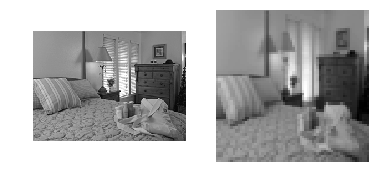

In [13]:
pred = predict('./test/Bedroom/image_0003.jpg', model)
print("The Predicted Label is {}".format(pred))
